# Дипломный проект: создание модели предсказания температуры на сталелитейном предприятии
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. <br>
Наша задача: построить модель, которая предскажет температуру стали.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## План работы
1. Преданализ и обработка данных - устранение аномальных значений, дубликатов, пропусков.
Заполнение пропусков нулями там, где это возможно.
2. Feature engineering в таблицах, где одной партии соответствует несколько строк: data_arc, data_temp. 
3. Объединение таблиц в один общий массив данных по номеру партии. Оставляем только те партии, где есть все данные.
4. Feature engineering данных на базе полного датасета. Проверка признаков на внутреннюю корреляцию и элиминирование тех признаков, которые имеют этот показатель выше 0.5.
5. Выделение 25% данных для тестовой выборки.
6. Подготовка признаков: разделение на features & target, масштабирование признаков при помощи scaling.
7. Обучение регрессионных моделей: Logistic regression, Decision Tree Regressor, SGDRegressor, CatBoost, Gradient Boosting методом кросс-валидации, ключевая метрика - МАЕ. Подбор параметров моделей.
8. Сравнение показателей по разным моделям и выбор лучшей модели.
9. Тестирование лучшей модели на тестовой выборке и расчет финального значения метрики. <br> <br>
Вопросов к заданию нет.

## Преданализ и предобработка данных

### Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings("ignore")

rs = 13022023

In [2]:
#импорт данных в переменные
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
# данные по электродам
display(data_arc.tail(10))
data_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390
14867,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.521811,0.378517
14868,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.518065,0.528780
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В датасете 14876 объектов, 3241 партия. Присутствуют выбросы в столбце Реактивная мощность.

In [4]:
# данные о подаче сыпучих материалов (объём)
display(data_bulk.tail(10))
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3119,3232,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,92.0,204.0
3120,3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,114.0,204.0
3121,3234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.0,204.0
3122,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,118.0,206.0
3123,3236,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.0,NaN,132.0,208.0
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В датасете 3129 записей по 3241 партиям. Это значит что некоторые партии пропущены, по ним данные отсутствуют. 
В некоторых столбцах количество заполненных строк значительно меньше, чем в остальных. Такие данные предлагается исключить из выборки как нерепрезентативные и бесполезные для модели.

In [5]:
# данные о подаче сыпучих материалов (время)
display(data_bulk_time.tail(10))
data_bulk_time.describe(include ='all')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3119,3232,NaN,NaN,2019-08-31 20:03:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 19:58:36,NaN,2019-08-31 19:58:36,2019-08-31 19:58:36
3120,3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 20:26:21,NaN,2019-08-31 20:26:21,2019-08-31 20:26:21
3121,3234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 20:58:45,2019-08-31 20:58:45
3122,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 21:29:26,NaN,2019-08-31 21:29:26,2019-08-31 21:29:26
3123,3236,NaN,NaN,2019-08-31 22:20:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:11:55,NaN,2019-08-31 22:11:55,2019-08-31 22:11:55
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-05-28 03:53:36,2019-08-08 10:16:41,2019-05-19 00:40:15,2019-05-07 22:59:48,2019-08-08 10:16:41,2019-08-07 06:26:20,2019-07-23 11:52:43,2019-07-05 17:46:11,2019-08-11 12:13:43,2019-05-17 08:34:33,2019-07-01 19:17:54,2019-05-05 00:39:35,2019-05-05 00:39:35,2019-06-05 03:19:27,2019-05-05 00:39:35
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В датасете то же количество объектов, что и в предыдущем. К этим данным должны быть применены те же правила предобработки, что и к предыдущему датасету.

In [6]:
# данные о продувке сплава газом
display(data_gas.tail(10))
data_gas.describe()

,key,Газ 1
3229,3232,8.630453
3230,3233,7.366606
3231,3234,9.110702
3232,3235,5.710729
3233,3236,6.958647
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


В датасете 3239 объектов по 3241 партии. Это значит, что некоторые партии пропущены, по ним данных нет.
Есть вероятность того, что в столбце Газ1 есть выбросы в сторону минимума и максимума, необходимо более детальное исследование распределения данных.

In [7]:
# результаты измерения температуры
display(data_temp.tail(10))
data_temp.describe()

,key,Время замера,Температура
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Данные по измеренной температуре имеют пропуски, которые должны быть исключены. Также есть данные, которые достаточно отдалены от средней (более чем на 3 стандартных отклонения), и необходимо исследовать их дополнительно на предмет выбросов.

In [8]:
# данные о проволочных материалах (объём)
display(data_wire.tail(10))
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,15.069600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,107.147033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,110.160957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,125.099525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,101.162880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


В датасете 3081 объект по 3241 партии, это значит, что не по всем партиям имеется информация. По некоторым столбцам заполненных данных имеется недостаточное количество, их будет сложно использовать для обучения модели.

In [9]:
# данные о проволочных материалах (время)
display(data_wire_time.tail(10))
data_wire_time.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,2019-08-31 20:02:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,2019-08-31 20:31:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,2019-08-31 21:03:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,2019-08-31 21:33:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,2019-08-31 22:19:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


В датасете то же количество объектов, что и в предыдущем. К этим данным должны быть применены те же правила предобработки, что и к предыдущему датасету.

### Анализ данных

Для начала переназовем столбцы в таблицах для более удобного обращения к ним впоследствии.

In [10]:
data_arc = data_arc.rename(columns = {'Начало нагрева дугой':'heating_start', 'Конец нагрева дугой':'heating_end',
       'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'})
data_bulk = data_bulk.rename(columns = {'Bulk 1':'bulk_1', 'Bulk 2':'bulk_2', 'Bulk 3':'bulk_3', 'Bulk 4':'bulk_4', 
                                        'Bulk 5':'bulk_5', 'Bulk 6':'bulk_6', 'Bulk 7':'bulk_7', 'Bulk 8':'bulk_8', 
                                        'Bulk 9':'bulk_9', 'Bulk 10':'bulk_10', 'Bulk 11':'bulk_11', 'Bulk 12':'bulk_12',
                                        'Bulk 13':'bulk_13', 'Bulk 14':'bulk_14', 'Bulk 15':'bulk_15'})
data_bulk_time = data_bulk_time.rename(columns = {'Bulk 1':'bulk_1', 'Bulk 2':'bulk_2', 'Bulk 3':'bulk_3', 'Bulk 4':'bulk_4', 
                                        'Bulk 5':'bulk_5', 'Bulk 6':'bulk_6', 'Bulk 7':'bulk_7', 'Bulk 8':'bulk_8', 
                                        'Bulk 9':'bulk_9', 'Bulk 10':'bulk_10', 'Bulk 11':'bulk_11', 'Bulk 12':'bulk_12',
                                        'Bulk 13':'bulk_13', 'Bulk 14':'bulk_14', 'Bulk 15':'bulk_15'})
data_gas = data_gas.rename(columns = {'Газ 1': 'gas_total'})
data_temp = data_temp.rename(columns = {'Время замера':'time_stamp', 'Температура':'measured_temp'})
data_wire = data_wire.rename(columns = {'Wire 1':'wire_1', 'Wire 2':'wire_2', 'Wire 3':'wire_3', 'Wire 4':'wire_4', 
                                        'Wire 5':'wire_5', 'Wire 6':'wire_6', 'Wire 7':'wire_7', 'Wire 8':'wire_8', 'Wire 9':'wire_9'})
data_wire_time = data_wire_time.rename(columns = {'Wire 1':'wire_1', 'Wire 2':'wire_2', 'Wire 3':'wire_3', 'Wire 4':'wire_4', 
                                        'Wire 5':'wire_5', 'Wire 6':'wire_6', 'Wire 7':'wire_7', 'Wire 8':'wire_8', 'Wire 9':'wire_9'})

In [11]:
# проверим как прошла замена на примере одного из датасетов
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Исследуем данные на графиках для более наглядной визуализации и легкой интерпретации.

In [12]:
#создадим функцию для выведения графика Гистограмма
def hist_graph(data, bins):
    try:
        for column in data.columns:
            plt.hist(data[column], bins = bins)
            plt.ylabel('Кол-во объектов')
            plt.title('Распределение данных')
            plt.grid(which = 'major')
            plt.legend(data.columns)
        plt.show;
    except:
        plt.hist(data, bins = bins)
        plt.ylabel('Кол-во объектов')
        plt.title('Распределение данных')
        plt.grid(which = 'major')
        plt.show;

In [13]:
#создадим функцию для выведения графика Ящик с усами
def box_plot_graph(data, figsize = (9,9)):
    data.plot(kind = 'box', figsize=figsize)
    plt.title('Диаграмма "Ящик с усами"')
    plt.show;

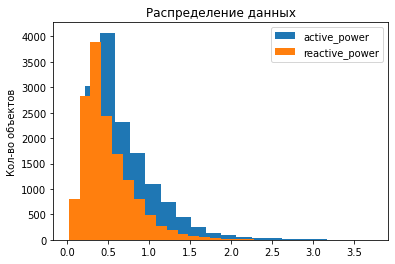

In [14]:
data_arc = data_arc[data_arc['reactive_power']>0] # тк в этом столбце были выбросы и аномалии, уберем их
hist_graph(data_arc[['active_power', 'reactive_power']], 20)

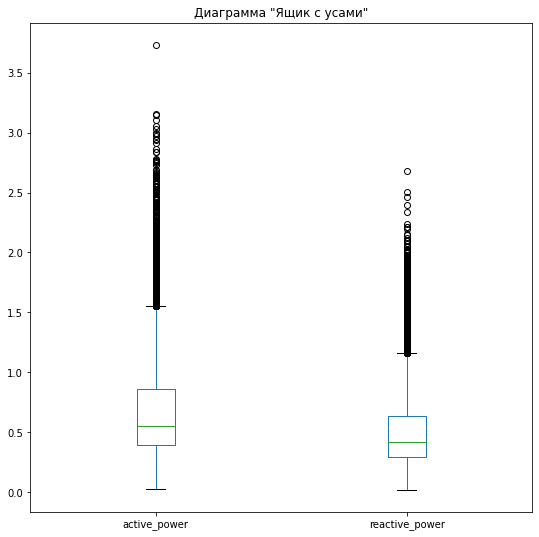

In [15]:
box_plot_graph(data_arc[['active_power', 'reactive_power']])

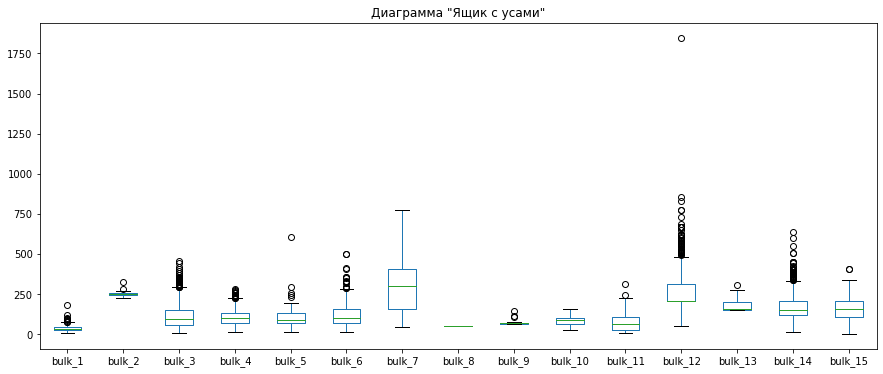

In [16]:
box_plot_graph(data_bulk.drop(['key'], axis = 1), figsize=(15,6))

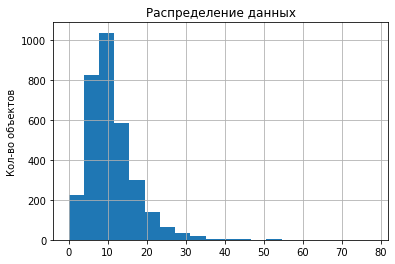

In [17]:
hist_graph(data_gas['gas_total'], 20)

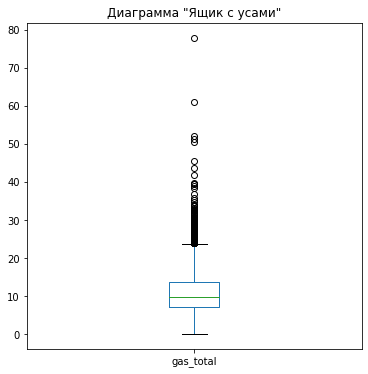

In [18]:
box_plot_graph(data_gas['gas_total'], figsize = (6,6))

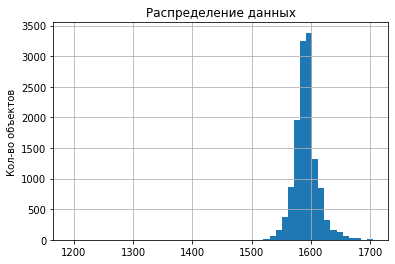

In [19]:
hist_graph(data_temp['measured_temp'], 50)

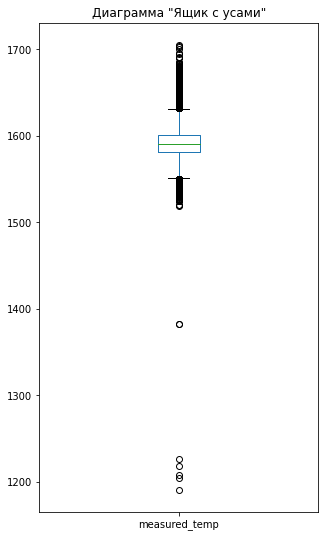

In [20]:
box_plot_graph(data_temp['measured_temp'], figsize=(5,9))

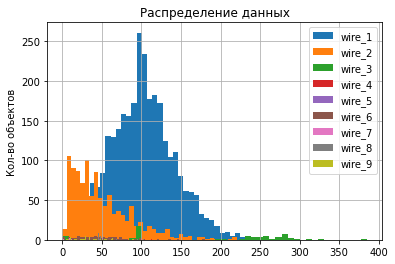

In [21]:
hist_graph(data_wire.drop(['key'], axis =1), 50)

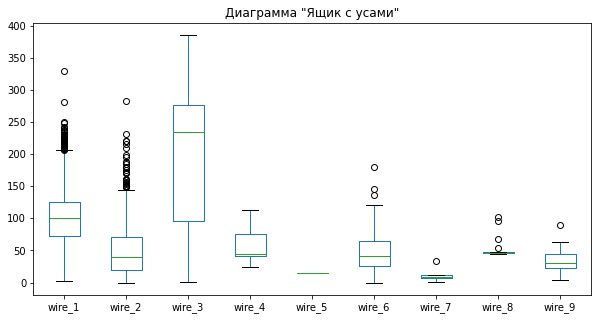

In [22]:
box_plot_graph(data_wire.drop(['key'], axis =1), figsize=(10,5))

**Выводы по графикам** <br>
При предобработке и подготовке данных для обучения моделей нам необходимо будет учесть следующее:
1. В таблице data_arc данные распределены нормально. Были аномалии в столбце reactive_power, которые пришлось исключить  до визуализации.
2. В таблице data_bulk есть аномалии в столбцах bulk_5 и bulk_12. 
3. В таблице data_gas данные распределены нормально. Есть единичные аномалии (от 40 и выше), но производство сообщило, что все данные по газу реальны. Оставим их для обучения модели.
4. В таблице data_temp данные распределены нормально и 99% значений сосредоточены между значениями 1500 и 1700. Значение вне этих диапазонов можно отбросить как аномальные.
5. В таблице data_wire мы видим, что основное количество данных - в столбцах wire_1 & wire_2. Там же имеются аномальные значение - свыше 200 в wire_1 и свыше 150 в wire_2. Данные в wire_3 распределены равномерно, выбросов нет. Данных по остальным столбцам недостаточно, чтобы явно судить о выбросах. <br>
На этапе подготовки данных для моделей мы очистим данные от аномалий.

### Oчистка данных от аномалий

Для начала выясним, есть ли в наших данных пропуски и дубликаты. Дубликаты необходимо удалить в любом случае, а пропуски необходимо удалить (в случае если это критично незаполненный пункт данных таргета или признаков) или заменить на соответствующее значение (если это некритичный или легко восполнимый пункт данных).

In [23]:
#создадим функцию выявления количества пропусков  и дубликатов
def null_duplicates(data):
    null = np.array(data.isnull().sum())
    if null.sum()>0:
        print('Есть пропуски в строках таблицы:')
        print(data.isnull().sum())
    else:
        print('Пропусков в датасете нет.')
    if data.duplicated().sum() >0:
        print('Есть дубликаты в строках таблицы:', data.is_duplicated().sum())
    else:
        print('Дубликатов в датасете нет.')

In [24]:
null_duplicates(data_arc)

Пропусков в датасете нет.
Дубликатов в датасете нет.


In [25]:
null_duplicates(data_bulk)

Есть пропуски в строках таблицы:
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
Дубликатов в датасете нет.


In [26]:
null_duplicates(data_bulk_time)

Есть пропуски в строках таблицы:
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
Дубликатов в датасете нет.


In [27]:
null_duplicates(data_gas)

Пропусков в датасете нет.
Дубликатов в датасете нет.


In [28]:
null_duplicates(data_temp)

Есть пропуски в строках таблицы:
key                 0
time_stamp          0
measured_temp    2901
dtype: int64
Дубликатов в датасете нет.


In [29]:
null_duplicates(data_wire)

Есть пропуски в строках таблицы:
key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64
Дубликатов в датасете нет.


In [30]:
null_duplicates(data_wire_time)

Есть пропуски в строках таблицы:
key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64
Дубликатов в датасете нет.


Дубликатов во всех имеющихся датасетах невыявлено. Пропуски есть в таблицах wire и bulk. Это соответстует техпроцессу: на стадии легирования добавляются не всегда одни и те же добавки. Если та или иная добавка не была добавлена, то система заполняет данные как N/a, хотя фактически количество добавленного материала просто равно 0. <br>
Мы можем заменить пропущенные данные в таблицах на 0. <br>

In [31]:
data_bulk = data_bulk.fillna(0)
data_bulk_time = data_bulk_time.fillna(0)
data_wire = data_wire.fillna(0)
data_wire_time = data_wire_time.fillna(0)

In [32]:
#чтобы убедиться, что замена прошла корректно, выведем на экран любой один датасет
display(data_wire.tail())
data_wire.info()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
3076,3237,38.088959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3080,3241,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Также есть пропуски в таблице temp. Т.к. это ключевая таблица, которая содержит значения таргета, нам необходимо подробнее изучить пропущенные значения.

In [33]:
rejected_batch = data_temp[data_temp['measured_temp'].isnull() == True]
rejected_batch

,key,time_stamp,measured_temp
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [34]:
batch_num= rejected_batch['key'].unique()
batch_num

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

У нас есть список партий, в которых данные по измерениям температуры неполные. Очевидно, что после 2500-й партии данные по измерениям у нас неполные. <br>
Из таблицы с температурами нас интересуют только первое измерение (это входная температура сплава) и последнее измерение температуры (это наш целевой признак). Остальные пропуски для нас не важны, их мы можем убрать из датасета. <br>
Мы соберем номера тех партий, где отсутствуют первое или последнее измерение, и после исключим эти партии из датасета.

In [35]:
#отфильтровываем все партии с null значениями
rejected_batch = data_temp.query('key in @batch_num')
display(rejected_batch.head())

#проверяем на заполнение первого и последнего измерения в каждой партии
rejected_batch=rejected_batch.fillna(0)  #заполняем пропущенные значения нулями
final_batch_num = []
for batch in batch_num:                  #проверяем, если нулю равная первая или последняя запись в партии, запоминаем партию
    table = rejected_batch[rejected_batch['key']==batch]
    if table.iloc[0,2]==0 or table.iloc[-1,2]==0:
        final_batch_num.append(batch)
final_batch_num

,key,time_stamp,measured_temp
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0


[2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 2641,
 2642,

Похоже, что в отфильтрованном списке партий все те же самые значения, но это не так важно. Теперь мы уверены, что удалим из датасета только те партии, в которых не содержится нужной нам информации.

In [36]:
data_temp = data_temp.query('key not in @final_batch_num')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            12267 non-null  int64  
 1   time_stamp     12267 non-null  object 
 2   measured_temp  12267 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.3+ KB


Теперь необходимо отбросить аномальные значения (они перечислены в выводах по графикам).

In [37]:
# data_temp - значения вне границ 1500 и 1700
data_temp = data_temp.query('measured_temp >1500 and measured_temp<1700')
# посмотрим на фрагмент датасета  и его статистики после преобразования
display(data_temp.tail())
data_temp.describe()

,key,time_stamp,measured_temp
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0
12266,2499,2019-08-06 03:00:28,1603.0


,key,measured_temp
count,12257.000000,12257.000000
mean,1235.602187,1592.121318
std,729.502502,19.385397
min,1.000000,1519.000000
25%,602.000000,1581.000000
50%,1238.000000,1591.000000
75%,1874.000000,1601.000000
max,2499.000000,1696.000000


In [38]:
# data_bulk: уберем строки с bulk_5 более 500 и bulk_12 более 1000
data_bulk = data_bulk.query('bulk_5 < 500 and bulk_12 <1000')
display(data_bulk.tail(10))
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
3119,3232,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,92.0,204.0
3120,3233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,114.0,204.0
3121,3234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262.0,204.0
3122,3235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,118.0,206.0
3123,3236,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.0,0.0,132.0,208.0
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000
mean,1624.741286,3.103294,1.780301,47.165974,33.824113,2.442597,21.906300,2.313399,0.015670,0.463703,4.687560,4.348257,203.420211,1.042533,152.569236,115.359770
std,933.339685,11.418543,21.224617,74.188575,56.050719,17.958449,55.507568,31.128112,0.876258,6.156356,20.163422,22.706575,148.581897,14.118742,80.649643,84.490298
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.500000,0.000000,0.000000,79.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,118.000000,325.000000,454.000000,281.000000,293.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,853.000000,305.000000,601.000000,405.000000


In [39]:
# data_wire: wire_1 < 200 & wire_2 < 150
data_wire = data_wire.query('wire_1 < 200 and wire_2 <150')
display(data_wire.tail(10))
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
3071,3232,15.069600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3072,3233,107.147033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3073,3234,110.160957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3074,3235,125.099525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3075,3236,101.162880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3076,3237,38.088959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3080,3241,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000
mean,1627.420878,98.171941,16.125045,3.612043,0.267354,0.005031,1.165306,0.036712,0.338723,0.276751
std,938.160023,40.416363,29.387609,29.115205,4.345478,0.275904,9.064421,0.783511,4.445372,3.559032
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,818.750000,70.106405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1630.500000,100.070877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2443.250000,124.211884,21.232639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,199.882806,148.930079,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Итак, мы обработали и подготовили все данные для последующего обучения моделей и тестирования.

## Подготовка обучающей и тестовой выборки и обучение модели

### Подготовка данных
Для обучения модели нам необходимо выбрать данные, которые могут стать адекватными признаками для обучения.
Мы будем использовать данные следующих таблиц: <br>
- data_arc
- data_bulk
- data_temp
- data_gas
- data_wire <br><br>
Таблицы data_bulk_time & data_wire_time не будут использоваться, т.к. содержат только данные о времени добавления ингридиентов, которые не могут быть соотнесены между таблицами, т.к. тайминговые датчики на разных стадиях показывают разное время. <br>
При этом данные в таблицах data_arc и data_temp должны быть агрегрированы по партиям. <br>
Мы объединим все таблицы в одну и оставим только те партии, которые содержат данные по всем полезным признакам. <br>
В качестве целевого признака мы будем использовать измеренную температуру в поле measured_temp таблицы data_temp, сделанную на последнем этапе. Температуру на первом этапе мы будем использовать в качестве признака.

In [40]:
# Для начала поработаем с таблицей data_arc - извлечем из данных новые признаки: 
# длительность нагрева, кол-во нагревов, полную мощность
# проверим тип данных и приведем даты к нужному типу
display(data_arc.info())
data_arc['heating_start']= pd.to_datetime(data_arc['heating_start'], format = '%Y/%m/%d %H:%M:%S')
data_arc['heating_end']= pd.to_datetime(data_arc['heating_end'], format = '%Y/%m/%d %H:%M:%S')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14875 non-null  int64  
 1   heating_start   14875 non-null  object 
 2   heating_end     14875 non-null  object 
 3   active_power    14875 non-null  float64
 4   reactive_power  14875 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14875 non-null  int64         
 1   heating_start   14875 non-null  datetime64[ns]
 2   heating_end     14875 non-null  datetime64[ns]
 3   active_power    14875 non-null  float64       
 4   reactive_power  14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


In [41]:
# создадим дополнительный столбец с продолжительностью нагрева
data_arc['heat_length_s'] = pd.TimedeltaIndex(data_arc['heating_end'] - data_arc['heating_start']).seconds
# и еще один дополнительный столбец - полная мощность = квадратный корень из суммы квадратов активной и реактивной мощностей
data_arc['apparent_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)
data_arc.head()

,key,heating_start,heating_end,active_power,reactive_power,heat_length_s,apparent_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239


In [42]:
data_arc_pivot = pd.pivot_table(data_arc, index = 'key', 
                                values = ['active_power', 'reactive_power', 'heat_length_s', 'apparent_power', 'heating_start'],
                               aggfunc = {'active_power':'mean', 
                                          'reactive_power':'mean', 
                                          'heat_length_s':'sum', 
                                          'apparent_power':'mean', 'heating_start':'count'})
data_arc_pivot.rename(columns = {'heating_start':'heating_count'}, inplace = True)
data_arc_pivot.head()

,active_power,apparent_power,heat_length_s,heating_count,reactive_power
key,,,,,
1,0.975629,1.165279,1098,5,0.636648
2,0.763150,0.912304,811,4,0.499528
3,0.505176,0.597907,655,5,0.319815
4,0.802313,0.953741,741,4,0.515074
5,0.836793,1.008939,869,4,0.563161


In [43]:
# в датасете data_temp нам нужны только первое и последнее значения температуры
# напишем функцию, которая возвращает только значение первой или последней записи для партии
# определим первую запись для партию как ту, у которой значение key не равно предыдущему
# а последнюю запись - как ту, у которой значение key не равно последующей записи

def first(line):
    cell = line['first_temp']
    if cell == True:
        return line['measured_temp']
    else:
        return 0
    
def last(line):
    cell = line['last_temp']
    if cell == True:
        return line['measured_temp']
    else:
        return 0
data_temp['first_temp'] = data_temp['key']!= data_temp['key'].shift(1)
data_temp['last_temp'] = data_temp['key']!= data_temp['key'].shift(-1)
data_temp['first_temp'] = data_temp.apply(first, axis =1)
data_temp['last_temp'] = data_temp.apply(last, axis =1)
data_temp.head(10)

,key,time_stamp,measured_temp,first_temp,last_temp
0,1,2019-05-03 11:16:18,1571.0,1571.0,0.0
1,1,2019-05-03 11:25:53,1604.0,0.0,0.0
2,1,2019-05-03 11:29:11,1618.0,0.0,0.0
3,1,2019-05-03 11:30:01,1601.0,0.0,0.0
4,1,2019-05-03 11:30:39,1613.0,0.0,1613.0
5,2,2019-05-03 11:37:27,1581.0,1581.0,0.0
6,2,2019-05-03 11:38:00,1577.0,0.0,0.0
7,2,2019-05-03 11:49:38,1589.0,0.0,0.0
8,2,2019-05-03 11:55:50,1604.0,0.0,0.0
9,2,2019-05-03 11:58:24,1608.0,0.0,0.0


In [44]:
data_temp_pivot = pd.pivot_table(data_temp, index = 'key', values = ['first_temp', 'last_temp'], aggfunc ='max')
data_temp_pivot = data_temp_pivot.astype('int')
data_temp_pivot.head()

,first_temp,last_temp
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602


In [45]:
# в таблицах data_bulk и data_wire дополнительным признаком может быть количество добавленных ингридиентов для каждой партии
data_bulk['count_bulk'] = np.sum(data_bulk>0, axis =1)-1
data_wire['count_wire'] = np.sum(data_wire>0, axis = 1)-1
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,count_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4


Мы можем приступить к объединению признаков в единую таблицу. За базу нам необходимо взять таблицу, содержащую целевой признак - это таблица data_temp_pivot (целевой признак - 'last temp'). К ней мы последовательно будем присоединять признаки из других таблиц - только для тех партий, которые содержатся в базовой таблице.

In [46]:
final_dataset = data_temp_pivot.merge(data_arc_pivot, left_index = True, right_index = True, how = 'inner')
data_gas.set_index(['key'], drop = True, inplace = True)
final_dataset = final_dataset.merge(data_gas, how = 'inner', left_index = True, right_on = 'key', copy = False)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 1 to 2499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_temp      2473 non-null   int64  
 1   last_temp       2473 non-null   int64  
 2   active_power    2473 non-null   float64
 3   apparent_power  2473 non-null   float64
 4   heat_length_s   2473 non-null   int64  
 5   heating_count   2473 non-null   int64  
 6   reactive_power  2473 non-null   float64
 7   gas_total       2473 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 173.9 KB


Далее мы будем объединять эту таблицу с данными таблиц data_bulk & data_wire. <br>
Не все столбцы в этих таблицах нам необходимы - если ингридиент добавлялся менее чем в 10% случаев, модель не сумеет его правильно обработать. Поэтому такие столбцы нам копировать не нужно.

In [47]:
#уберем из таблиц столбцы, где кол-во заполненных строк менее 10% = 30
#сначала сделаем индекс таблице по столбцу key, чтобы потом его тоже убрать
data_bulk.set_index(['key'], drop = True, inplace = True)
data_wire.set_index(['key'], drop = True, inplace = True)
data_bulk = data_bulk.drop(['bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13'], axis=1)
data_wire = data_wire.drop(['wire_4', 'wire_5', 'wire_7', 'wire_8', 'wire_9'], axis=1)
data_bulk.head()

,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,count_bulk
key,,,,,,,,,,,
1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,4
2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,4
3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,4
4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,4
5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,4


In [48]:
final_dataset

,first_temp,last_temp,active_power,apparent_power,heat_length_s,heating_count,reactive_power,gas_total
key,,,,,,,,
1,1571,1613,0.975629,1.165279,1098,5,0.636648,29.749986
2,1581,1602,0.763150,0.912304,811,4,0.499528,12.555561
3,1596,1599,0.505176,0.597907,655,5,0.319815,28.554793
4,1601,1625,0.802313,0.953741,741,4,0.515074,18.841219
5,1576,1602,0.836793,1.008939,869,4,0.563161,5.413692
...,...,...,...,...,...,...,...,...
2495,1570,1591,0.802673,0.996717,723,4,0.590194,7.125735
2496,1554,1591,0.700511,0.842839,940,6,0.468364,9.412616
2497,1571,1589,0.737460,0.961672,569,3,0.617090,6.271699


In [49]:
final_dataset = final_dataset.merge(data_bulk, left_index = True, 
                                    right_index = True, how = 'inner', copy= False)
final_dataset = final_dataset.merge(data_wire, left_index = True, 
                                    right_index = True, how = 'inner', copy = False)
display(final_dataset.head())
final_dataset.info()

,first_temp,last_temp,active_power,apparent_power,heat_length_s,heating_count,reactive_power,gas_total,bulk_1,bulk_3,...,bulk_11,bulk_12,bulk_14,bulk_15,count_bulk,wire_1,wire_2,wire_3,wire_6,count_wire
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,0.975629,1.165279,1098,5,0.636648,29.749986,0.0,0.0,...,0.0,206.0,150.0,154.0,4,60.059998,0.00000,0.0,0.0,1
2,1581,1602,0.763150,0.912304,811,4,0.499528,12.555561,0.0,0.0,...,0.0,206.0,149.0,154.0,4,96.052315,0.00000,0.0,0.0,1
3,1596,1599,0.505176,0.597907,655,5,0.319815,28.554793,0.0,0.0,...,0.0,205.0,152.0,153.0,4,91.160157,0.00000,0.0,0.0,1
4,1601,1625,0.802313,0.953741,741,4,0.515074,18.841219,0.0,0.0,...,0.0,207.0,153.0,154.0,4,89.063515,0.00000,0.0,0.0,1
5,1576,1602,0.836793,1.008939,869,4,0.563161,5.413692,0.0,0.0,...,0.0,203.0,151.0,152.0,4,89.238236,9.11456,0.0,0.0,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2264 entries, 1 to 2499
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_temp      2264 non-null   int64  
 1   last_temp       2264 non-null   int64  
 2   active_power    2264 non-null   float64
 3   apparent_power  2264 non-null   float64
 4   heat_length_s   2264 non-null   int64  
 5   heating_count   2264 non-null   int64  
 6   reactive_power  2264 non-null   float64
 7   gas_total       2264 non-null   float64
 8   bulk_1          2264 non-null   float64
 9   bulk_3          2264 non-null   float64
 10  bulk_4          2264 non-null   float64
 11  bulk_5          2264 non-null   float64
 12  bulk_6          2264 non-null   float64
 13  bulk_10         2264 non-null   float64
 14  bulk_11         2264 non-null   float64
 15  bulk_12         2264 non-null   float64
 16  bulk_14         2264 non-null   float64
 17  bulk_15         2264 non-null   f

Итого, в нашем датасете осталось всего 2242 партии и 24 столбца, из которых один - last_temp - целевой признак и 23 признака могут быть использованы для обучения. <br>
Прежде чем приступать к обучению моделей, исследуем признаки на корреляцию и взаимозависимость при помощи инструмента corr_matrix.

In [50]:
corr_matrix = final_dataset.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,first_temp,last_temp,active_power,apparent_power,heat_length_s,heating_count,reactive_power,gas_total,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,count_bulk,wire_1,wire_2,wire_3,wire_6,count_wire
first_temp,1.000000,0.294322,-0.516792,-0.514999,-0.405820,-0.194925,-0.484556,0.027063,0.075426,-0.123565,0.164035,0.078779,-0.139158,0.035161,-0.109887,-0.087972,-0.186573,-0.060975,-0.070262,0.247849,-0.135001,-0.004715,0.022817,-0.062795
last_temp,0.294322,1.000000,0.202572,0.182919,0.270275,0.173726,0.142970,0.055415,-0.095637,-0.038012,0.181629,-0.050130,-0.180496,0.051987,-0.116741,0.259713,0.106826,0.267370,0.098639,0.305285,-0.214416,-0.047311,-0.085836,-0.196016
active_power,-0.516792,0.202572,1.000000,0.988324,0.567958,0.034341,0.922658,0.094417,0.030380,0.064498,-0.046141,-0.068715,0.048158,-0.015250,0.034256,0.400370,0.353197,0.347628,0.267048,-0.111900,0.008131,0.008056,0.037829,-0.015832
apparent_power,-0.514999,0.182919,0.988324,1.000000,0.574474,0.034852,0.970395,0.085072,0.040119,0.042415,-0.048360,-0.064943,0.044917,-0.018232,0.038124,0.399785,0.343141,0.337141,0.258310,-0.129633,0.003934,0.003893,0.035604,-0.021974
heat_length_s,-0.405820,0.270275,0.567958,0.574474,1.000000,0.794869,0.553641,0.378445,0.068748,0.097924,-0.032244,0.030013,0.162804,-0.015053,0.082722,0.450547,0.451743,0.296155,0.337870,0.038370,0.040894,0.039681,0.044871,0.035845
heating_count,-0.194925,0.173726,0.034341,0.034852,0.794869,1.000000,0.029151,0.392857,0.065774,0.109728,-0.003242,0.117290,0.149302,0.001676,0.067156,0.286161,0.320601,0.166838,0.294240,0.130631,0.053150,0.061830,0.056605,0.073463
reactive_power,-0.484556,0.142970,0.922658,0.970395,0.553641,0.029151,1.000000,0.064400,0.056646,0.002994,-0.049145,-0.056190,0.035850,-0.021599,0.041630,0.381605,0.309806,0.307085,0.233581,-0.152308,-0.004331,-0.003101,0.029837,-0.032176
gas_total,0.027063,0.055415,0.094417,0.085072,0.378445,0.392857,0.064400,1.000000,0.168746,0.053863,0.024308,0.128128,0.144588,-0.012528,0.048593,0.167252,0.253600,0.049961,0.221715,0.100723,0.066883,0.112464,0.116721,0.137834
bulk_1,0.075426,-0.095637,0.030380,0.040119,0.068748,0.065774,0.056646,0.168746,1.000000,-0.018477,0.044846,0.087413,0.003782,-0.026136,-0.038685,0.272616,0.176510,0.007202,0.272273,0.017312,-0.051086,0.024928,0.161197,0.039262
bulk_3,-0.123565,-0.038012,0.064498,0.042415,0.097924,0.109728,0.002994,0.053863,-0.018477,1.000000,-0.295715,-0.041499,0.071799,-0.085817,-0.005562,0.019659,0.015478,-0.011479,0.163274,0.025450,0.076185,0.002612,0.008440,0.047226


Высокая корреляция (более |0.5|) наблюдается между следующими признаками:
1. между heat_length <-> heating_count => можно исключить последний
2. между active_power, apparent_power, reactive_power, heat_length => из них можем оставить только один признак, и это должен быть apparent_power, т.к. он уже включает в себя активную и реактивную мощности
3. между bulk_12, bulk_15 и count_bulk, но это объяснимо тех процессом, так что убирать ничего не будем
4. между wire_2 и count_wire, но это также объяснимо с точки зрения тех процесса, убрать не будем

In [51]:
final_dataset= final_dataset.drop(['active_power', 'reactive_power', 'heating_count'], axis =1)
corr_matrix =final_dataset.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,first_temp,last_temp,apparent_power,heat_length_s,gas_total,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,count_bulk,wire_1,wire_2,wire_3,wire_6,count_wire
first_temp,1.000000,0.294322,-0.514999,-0.405820,0.027063,0.075426,-0.123565,0.164035,0.078779,-0.139158,0.035161,-0.109887,-0.087972,-0.186573,-0.060975,-0.070262,0.247849,-0.135001,-0.004715,0.022817,-0.062795
last_temp,0.294322,1.000000,0.182919,0.270275,0.055415,-0.095637,-0.038012,0.181629,-0.050130,-0.180496,0.051987,-0.116741,0.259713,0.106826,0.267370,0.098639,0.305285,-0.214416,-0.047311,-0.085836,-0.196016
apparent_power,-0.514999,0.182919,1.000000,0.574474,0.085072,0.040119,0.042415,-0.048360,-0.064943,0.044917,-0.018232,0.038124,0.399785,0.343141,0.337141,0.258310,-0.129633,0.003934,0.003893,0.035604,-0.021974
heat_length_s,-0.405820,0.270275,0.574474,1.000000,0.378445,0.068748,0.097924,-0.032244,0.030013,0.162804,-0.015053,0.082722,0.450547,0.451743,0.296155,0.337870,0.038370,0.040894,0.039681,0.044871,0.035845
gas_total,0.027063,0.055415,0.085072,0.378445,1.000000,0.168746,0.053863,0.024308,0.128128,0.144588,-0.012528,0.048593,0.167252,0.253600,0.049961,0.221715,0.100723,0.066883,0.112464,0.116721,0.137834
bulk_1,0.075426,-0.095637,0.040119,0.068748,0.168746,1.000000,-0.018477,0.044846,0.087413,0.003782,-0.026136,-0.038685,0.272616,0.176510,0.007202,0.272273,0.017312,-0.051086,0.024928,0.161197,0.039262
bulk_3,-0.123565,-0.038012,0.042415,0.097924,0.053863,-0.018477,1.000000,-0.295715,-0.041499,0.071799,-0.085817,-0.005562,0.019659,0.015478,-0.011479,0.163274,0.025450,0.076185,0.002612,0.008440,0.047226
bulk_4,0.164035,0.181629,-0.048360,-0.032244,0.024308,0.044846,-0.295715,1.000000,0.033695,-0.252113,-0.082954,-0.120878,0.102552,-0.095143,0.105716,0.107856,0.304142,-0.273407,-0.037626,-0.011443,-0.213224
bulk_5,0.078779,-0.050130,-0.064943,0.030013,0.128128,0.087413,-0.041499,0.033695,1.000000,-0.023367,-0.030575,-0.016256,-0.085603,-0.072501,-0.075067,0.078542,-0.016888,-0.008150,0.091790,0.253711,0.115411
bulk_6,-0.139158,-0.180496,0.044917,0.162804,0.144588,0.003782,0.071799,-0.252113,-0.023367,1.000000,-0.097828,0.204246,-0.105013,0.186619,-0.113294,0.127637,-0.245975,0.163737,-0.046663,-0.020207,0.082410


В итоге, после проверки корреляции у нас осталось 19 признаков, на которых мы будем обучать наши модели.

### Подготовка обучающей и тестовой выборки

По условиям задачи, 25% от нашего финального датасета мы резервируем для тестирования модели. Это вполне адекватная доля при условии, что наш датасет очень небольшой.

In [52]:
features = final_dataset.drop(['last_temp'], axis =1)
target = final_dataset['last_temp']
features_train,features_test, target_train,  target_test = train_test_split(features, target,
                                                                            test_size = 0.25,
                                                                            random_state = rs)

Признаки, используемые для обучения, мы должны масштабировать до обучения модели, чтобы сбалансировать вес всех признаков между собой.

In [53]:
scaler = StandardScaler()
scaler.fit(features_train)
features_scaled = pd.DataFrame(scaler.transform(features_train), columns = features_train.columns)
features_test_scaled = scaler.transform(features_test)
features_scaled


,first_temp,apparent_power,heat_length_s,gas_total,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,count_bulk,wire_1,wire_2,wire_3,wire_6,count_wire
0,0.136807,-0.395994,-1.148075,-0.326166,-0.283544,2.546679,-0.634208,-0.131006,-0.399492,-0.241482,-0.188736,1.025873,0.515122,-0.229747,0.330241,-0.301909,-0.550152,-0.108753,-0.113738,-0.697268
1,0.179721,-1.058049,-0.064178,0.313736,-0.283544,-0.627978,-0.634208,-0.131006,1.949823,-0.241482,-0.188736,-0.678916,1.970965,-1.430271,-0.489567,-1.540021,-0.550152,-0.108753,-0.113738,-0.697268
2,0.394295,-0.998648,-0.761404,-0.796214,-0.283544,0.479775,1.180884,-0.131006,-0.399492,-0.241482,-0.188736,-0.020696,-0.533578,-0.217861,1.150048,0.280304,-0.550152,-0.108753,-0.113738,-0.697268
3,0.694699,-2.132835,-1.540836,0.035914,-0.283544,-0.627978,2.010641,-0.131006,-0.399492,-0.241482,-0.188736,-0.672334,-0.101760,-0.788407,0.330241,0.499847,-0.550152,-0.108753,-0.113738,-0.697268
4,-0.678574,-0.208111,0.285957,-0.413547,-0.283544,-0.627978,1.371037,-0.131006,-0.399492,-0.241482,-0.188736,0.683598,0.552135,0.424003,0.330241,-0.495222,-0.550152,-0.108753,-0.113738,-0.697268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,0.780528,-0.964983,-0.262081,-0.000815,-0.283544,-0.627978,-0.634208,-0.131006,0.992025,-0.241482,-0.188736,-1.370046,1.206031,0.982663,-0.489567,-0.712187,1.254490,-0.108753,-0.113738,1.113070
1694,-0.807319,0.879209,-0.015464,-1.597891,-0.283544,-0.627978,0.852439,-0.131006,-0.399492,-0.241482,-0.188736,-0.007532,-0.644617,-0.217861,0.330241,0.183648,-0.550152,-0.108753,-0.113738,-0.697268
1695,2.196716,0.668842,1.707811,-0.036539,-0.283544,1.425417,-0.634208,-0.131006,-0.399492,-0.241482,-0.188736,1.973709,0.626161,1.006436,0.330241,-0.909138,0.710885,-0.108753,-0.113738,1.113070
1696,-0.635659,-0.412959,-0.045910,-0.288582,-0.283544,-0.627978,-0.634208,-0.131006,-0.399492,-0.241482,-0.188736,1.341818,1.317069,0.994549,-0.489567,-2.126934,-0.550152,-0.108753,-0.113738,-0.697268


Теперь все готово к выбору и обучению моделей.

Мы будем использовать GridSearchCV для подбора параметров моделей, запоминать метрики и лучшие параметры моделей. Напишем для этого простую функцию.

In [54]:
def model_select(model, params, features, target, cv=5):
    clf = GridSearchCV(model, param_grid = params, scoring = 'neg_mean_absolute_error', cv=cv, verbose =0)
    clf.fit(features, target)
    score = abs(clf.best_score_)
    params = clf.best_params_
    print('Лучший результат метрики МАЕ модели: ', score)
    print('при следующих параметрах:')
    print(params)
    return score, params

Для начала создадим Dummy модель, которая делает предсказанием простым средним, чтобы иметь референс для сравнения.

**Модель Dummy**

In [55]:
dummy = DummyRegressor(strategy = 'mean')
dummy.fit(features_scaled, target_train)
dummy_result=abs(np.mean(cross_val_score(dummy, X=features_scaled, 
                                     y=target_train, 
                                     scoring='neg_mean_absolute_error', cv=5)))
print('MAE модели-заглушки:', dummy_result)

MAE модели-заглушки: 8.031051703246241


**Модель Decision Tree Regressor**

In [56]:
model_DTR = DecisionTreeRegressor(random_state = rs)
params = {'max_depth':(2,8), 'min_samples_leaf': (1,7)}
DTR_score, DTR_params= model_select(model_DTR, params, features_scaled, target_train)

Лучший результат метрики МАЕ модели:  7.238392632050262
при следующих параметрах:
{'max_depth': 8, 'min_samples_leaf': 7}


**Модель Linear Regression**

In [57]:
model_LR = LinearRegression()
params = {'n_jobs':range(1, 5), 
          'fit_intercept': ('True', 'False')}
LR_score, LR_params = model_select(model_LR, params, features_scaled, target_train)

Лучший результат метрики МАЕ модели:  6.203227399141907
при следующих параметрах:
{'fit_intercept': 'True', 'n_jobs': 1}


**Модель SGD Regressor**

In [58]:
model_SGD = SGDRegressor(shuffle= True, random_state = rs)
params = {'alpha':[0.01, 0.001, 0.0001, 0.00001], 'max_iter':range(1, 101, 10)}
SGD_score, SGD_params = model_select(model_SGD, params, features_scaled, target_train)

Лучший результат метрики МАЕ модели:  6.229865531787928
при следующих параметрах:
{'alpha': 0.01, 'max_iter': 31}


**Модель CatBoostRegressor**

In [59]:
model_CBR = CatBoostRegressor(loss_function="RMSE", verbose=0)
params = {'iterations':range(100, 201, 20), 
          'learning_rate':[0.1, 0.03, 0.01, 0.003, 0.001, 0.0001], 
          'max_depth':range(3, 9)}
CBR_score, CBR_params = model_select(model_CBR, params, features_scaled, target_train)

Лучший результат метрики МАЕ модели:  5.870654689255377
при следующих параметрах:
{'iterations': 160, 'learning_rate': 0.1, 'max_depth': 5}


Cоздадим таблицу с результатами всех моделей для сравнительного анализа.

In [61]:
index = ['Dummy', 'DecisionTreeRegressor', 'LinearRegression', 'SGD Regressor', 'CatBoostRegressor']
table = pd.DataFrame(data=(dummy_result, DTR_score, LR_score, SGD_score, CBR_score), index= index, columns=['MAE'])
table.style.background_gradient(cmap='coolwarm')
print('Сравнительная таблица результатов обучения моделей:')
display(table)

Сравнительная таблица результатов обучения моделей


,MAE
Dummy,-8.031052
DecisionTreeRegressor,7.238393
LinearRegression,6.203227
SGD Regressor,6.229866
CatBoostRegressor,5.870655


Очевидно, что лучший результат показала модель CatBoostRegressor. <br>
Проверим результаты работы модели на тестовой выборке на лучших параметрах.

In [62]:
CBR_params

{'iterations': 160, 'learning_rate': 0.1, 'max_depth': 5}

In [64]:
model_CBR = CatBoostRegressor(loss_function ='RMSE', iterations = 160, learning_rate =0.1, max_depth =5, verbose=0)
model_CBR.fit(features_scaled, target_train)
MAE = mean_absolute_error(model_CBR.predict(features_test_scaled), target_test)
print('Показатель метрики МАЕ модели CatBoost на тестовой выборке:', MAE)

Показатель метрики МАЕ модели CatBoost на тестовой выборке: 5.769144168070243


# Итоговый вывод

Итак, в ходе нашего исследования мы предприняли следующие шаги:
1. Выгрузили данные и сделали предпросмотр.
2. Очистили данные от аномалий.
3. Проанализировали статистические показатели данных.
4. Выявили признаки, которые необходимо использовать для обучения модели, а также создали несколько дополнительных. Отмели те данные, которые не имеют добавленной ценности при обучении модели.
5. Объединили таблицы в единый датасет признаков, включив в него только те партии, данные по которым содержали всю необходимую нам информацию.
6. Разбили данные на тестовую и трейновую выборки. Масштабировали признаки.
7. Обучили несколько моделей регрессии, получили предсказания и показатель метрики для каждой методом кросс-валидации. Подобрали оптимальные параметры для каждой модели. Также создали константную модель-заглушку для референса.
8. Выбрали модель с оптимальным показателем метрики и провели тестирование модели.
9. Убедились, что результат предсказания модели выходит на необходимый уровень точности - отклонение не более 6 градусов.

В ходе работы мы полностью придерживались изначально намеченного плана. Никаких дополнительных и непредвиденных этапов не потребовалось.

Характерные особенности проекта, с которыми пришлось столкнуться в ходе выполнения проекта:
1. Разрозненная выборка данных, распределенная по разным таблицам. Для получения полного датасета признаков потребовалось объединение всех данных в единый датасет по ключу - полю с номером партии 'key'. 
2. Тайминговые характеристики каждого из датасетов не соответствовали остальным, поэтому часть полезной информации не могла быть получена (например, временной разрыв между нагреванием и измерением температуры, между добавлением ингридиентов и нагревание, и пр.) <br> Можно рекомендовать производственному департаменту синхронизировать тайминговые устройства различных этапов, для получение дополнительных источников информация для модели.
3. Из-за недостаточного количества данных по некоторым этапам (например, добавление опреденных видов ингридиентов во время легирования стали) эти данные пришлось вообще отбросить. Это значит что при необходимости модель не сможет обработать информацию такого рода и выдать корректный результат. <br> Можно рекомендовать собрать дополнительную расширенную информацию, включающую в себя репрезентативное количество данных по редким ингридиентам, и впоследствии переобучить модель на новых данных.


Для нашей модели мы выделили определенный набор признаков, которые могут принести пользу при обучении модели: <br>
    - first_temp - температура сплава на входе <br>
    - apparent_power - полная мощность, рассчитанная как функция от активной и реактивной мощности. Сами активная и реактивная мощность были исключены из признаков, т.к. имеют высокий процент корреляции между собой и с признаком полной мощности <br>
    - heat_length_s - продолжительность нагрева в секундах, рассчитанная как суммарная разница между моментом начала нагревания и окончания нагревания сплава <br>
    - gas_total - суммарное количество потребленного газа при продувании, на партию <br>
    - признаки с количеством потребленных ингридиентов (хим.добавок bulk и проволоки wire) <br>
Некоторые признаки, в том числе дополнительно рассчитанные на предыдущих этапах, пришлось исключить после проверки признаков на корреляцию. Это важно в том числе и для того, чтобы не повышать значимость одних и тех же физических факторов, влияющих на процесс, путем увеличения количества признаков, завязанных на этот фактор.

После обучения различных моделей регрессии и сравнения результатов, мы сделали вывод, что:
1. Регрессия дерева решений **Decision Tree regressor*** плохо справляется с поставленной задачей, ее показатель МАЕ ***7.3*** не сильно опережает показатель константной модели, просто прогнозирующей результат как среднее арифметичское температур трейновой выборки (***8.0***).
2. ***Линейная регрессия*** и ***градиентный спуск*** дают практически одинаковые (и в целом неплохие) результаты на уровне МАЕ ***6.2***.
3. Лидером среди использованных моделей стала ***CatBoost*** с показателем МАЕ на трейновой выборке ***5.8***. Бустинговые модели, как правило, хорошо проявляют себя в задачах подобного типа, т.к. последовательно объединяют несколько более "слабых" деревьев решений. Бустинг имеет несколько итераций, каждая из которых минимизирует функцию потерь и измеряет "расстояние" до оптимального значения. <br>
В нашем случае оптимальное количество итераций *iterations*, подобранное при помощи GridSearchCV, равно *160*, что позволяет нам, с одной стороны, достаточно глубоко проработать внутренние зависимости и приблизиться к оптимальному результату, а с другой, - не переобучить модель избыточным количеством итераций. <br>
Распространенным недостатком бустинговых моделей по сравнению с более простыми моделями является время обучения и предсказания. Однако в нашем случае, в том числе за счет скорости обучения *learning_rate = 0.1*, эта проблема неактуальна - модель обучается достаточно быстро. <br>
Максимально разрешенная глубина каждого дерева в рамках ансамбля бустингов нашей модели *max_depth = 5*, что так же помогает бороться с переобучением, по сравнению с более глубокими деревьями.

**ВАЖНО!** Оптимальная метрика в 5,8 на валидационной выборке и 5,7 на тестовой выборке достигается при наличии однородных данных по имеющимся признакам и не настроена на предсказание радикально отличающихся параметров.
При возможности / наличии новых дополнительных данных, указанных в пунктах выше, потребуется переобучение модели на релевантных данных.

**Рекомендации**. Рекомендуется использовать данную модель для предсказания температуры сплава, и таким образом достичь цели компании - экономии средств за счет оптимизации количество использованной электроэнергии.